## Initial Setup

In [ ]:
%%capture
#%%script false
!pip install shap==0.23.0
!pip install xgboost==0.82
!pip install catboost
!pip install lightgbm==2.2.4
#!pip install tensorboardcolab
!pip install seaborn==0.9.0
!pip install pandas==0.24.2
!pip install numpy==1.16.2
!pip install eli5
#!pip install scikit-optimize==0.6

#Restart Runtime

## Data

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline
plt.rc('figure', figsize=(20.0, 6.0))

import shap
from tqdm import tqdm_notebook as tqdm

#from sklearn.externals import joblib
from sklearn.model_selection import train_test_split
#from sklearn.model_selection import StratifiedShuffleSplit #, RepeatedKFold, StratifiedKFold, RepeatedStratifiedKFold

import xgboost as xgb
import lightgbm as lgb
import catboost as cat

#import sklearn.svm as svm
#import sklearn.neighbors as knn


from sklearn.model_selection import cross_val_score
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import classification_report, confusion_matrix, roc_curve, roc_auc_score, auc, f1_score
#from sklearn.metrics import mean_squared_error #, mean_squared_log_error

In [ ]:
np.array([["TN", "FP"],["FN", "TP"]])

array([['TN', 'FP'],
       ['FN', 'TP']], dtype='<U2')

In [ ]:
train_data_og = pd.read_csv("https://drive.google.com/uc?export=download&id=1qxyADnYxoByhG86jZ8aHDjmvil2r9SRN")
sub_data_og = pd.read_csv("https://drive.google.com/uc?export=download&id=1indvevIun1vXhQJs8kJ4Hri3RgWFfhrU")

In [ ]:
f1_score(train_data_og.sentiment, np.ones(5279), average = "macro")

/usr/local/lib/python3.6/dist-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


0.09123610202746892

### Manipulation

Mean Encoding.  
Divide and Multiply columns.  


Time Series  
Date parts  
Lag values  
Difference between dates 

In [ ]:
# 0 positive, 1 negative and 2 neutral
def clean_data(dataset):
    
    op_set_1 = (dataset
                    .assign( Length = dataset.text.str.lower().str.len() )
                    .assign( Punc = dataset.text.str.lower().str.len() - dataset.text.str.lower().str.count("[a-z0-9]") )
               )
    
    return op_set_1

train_data = clean_data(train_data_og)
train_data.head(10)

,unique_hash,text,drug,sentiment,Length,Punc
0,2e180be4c9214c1f5ab51fd8cc32bc80c9f612e0,Autoimmune diseases tend to come in clusters. ...,gilenya,2,404,97
1,9eba8f80e7e20f3a2f48685530748fbfa95943e4,I can completely understand why you’d want to ...,gilenya,2,1184,245
2,fe809672251f6bd0d986e00380f48d047c7e7b76,Interesting that it only targets S1P-1/5 recep...,fingolimod,2,780,191
3,bd22104dfa9ec80db4099523e03fae7a52735eb6,"Very interesting, grand merci. Now I wonder wh...",ocrevus,2,124,23
4,b227688381f9b25e5b65109dd00f7f895e838249,"Hi everybody, My latest MRI results for Brain ...",gilenya,1,612,133
5,a043780c757966243779bf3c0d11bf6eef721971,I can’t give you advice about Lemtrada because...,cladribine,2,285,57
6,be5a13376933a7f9bbf8e801c31691092f63260a,Reply posted for JessZidek. Hi Jess Sorry to r...,humira,0,755,145
7,08c3c0c702fc97d290204b37798ac62005da5626,Well as expected my Neurologist wants me to st...,gilenya,2,723,158
8,8fd3d7ad80791c9343e5cf8a83bd1adf6577d516,Why do you think that FIngolimod was such a mi...,fingolimod,1,296,56
9,793c5af7cc8332df17eb602247d886fbd1c80f89,Thank you so much…I’m learning a lot here at G...,tagrisso,2,927,199


In [ ]:
train_data.query("sentiment == 0")

,unique_hash,text,drug,sentiment,Length,Punc
6,be5a13376933a7f9bbf8e801c31691092f63260a,Reply posted for JessZidek. Hi Jess Sorry to r...,humira,0,755,145
28,e8f39b50683bb1b94689e8e462bdcd1aff331ee1,"Last Updated: January 01, 2017. Share | Comme...",ocrelizumab,0,18499,3650
29,c2df2a0e70805bb1a17305e2ac137aeae26d424a,Hi I was on rebif for about a year – rotate yo...,fingolimod,0,263,58
34,603c2f1612eeabcaac016b6da0df4117b6a8ccd8,No problem. I know how hard and lonely this jo...,tecentriq,0,1294,278
42,918b3d83f17c334962f30974f2ff1f16630eebf0,Conclusion: These real-life results suggest th...,dexamethasone implant,0,170,26
60,92b34902563dbaa5352fad47791aa23daafde08b,"At a glance, Cladribine looks significantly be...",cladribine,0,75,12
63,5464b1ed8ae3bb6cf2a50ce92b997af10ff374a5,"Hi Janine, Thanks for your response but due to...",tagrisso,0,1003,205
75,358e2b9747c7ddc7e14f181bdafffd984a07f92f,Health Canada has approved Mavenclad as a ther...,mavenclad,0,285,49
77,fd07fdfd6463392475fa70912d0aeaee743c80b9,I am on a Lag3 plus Opdivo clinical trial. I h...,opdivo,0,454,107
87,7cafe0a71be5ce964c4f1326068be7092b876cef,My 45 year old husband was diagnosed with PPMS...,ocrevus,0,314,60


In [ ]:
train_data.text.loc[29].lower()

'hi i was on rebif for about a year – rotate your injection sites and remember to take pain relief afterwards as you will et flu symptoms. i used aloe vera gel on the injection sites. i had a relapse on rebif so will now go on to fingolimod. good luck with it all.'

In [ ]:
train_data.text.str.lower().str.extract("(gilenya)")

,0
0,gilenya
1,gilenya
2,NaN
3,NaN
4,gilenya
5,NaN
6,NaN
7,gilenya
8,NaN
9,NaN


In [ ]:
sub_data = clean_data(sub_data_og)
sub_data.head()

,unique_hash,text,drug,Length,Punc
0,9e9a8166b84114aca147bf409f6f956635034c08,"256 (previously stable on natalizumab), with 5...",fingolimod,72,13
1,e747e6822c867571afe7b907b51f0f2ca67b0e1a,On fingolimod and have been since December 201...,fingolimod,146,30
2,50b6d851bcff4f35afe354937949e9948975adf7,Apparently it's shingles! :-/ I do have a few ...,humira,1035,236
3,7f82ec2176ae6ab0b5d20b5ffc767ac829f384ae,If the Docetaxel doing once a week x3 weeks th...,tagrisso,918,235
4,8b37d169dee5bdae27060949242fb54feb6a7f7f,"CC, Stelara worked in a matter of days for me....",stelara,3168,712


In [ ]:
train_data[train_data.duplicated("text")]

,unique_hash,text,drug,sentiment,Length,Punc
633,026b8f717d0bf770bc27fefe3e7f0234428cfb79,"Sorry about that, Lab. Being forced to doctor-...",humira,2,1022,241
637,9e94c38585be70d0ea2ed9d86d6fdff976edc4b6,I've got to agree with iPoop. Long-term pred s...,entyvio,2,905,203
891,f2799a8d9246c4f65abaf0dc83f19eab2e884852,Posted in the past following mixed response ab...,pemetrexed,2,1933,385
1196,3d0b6ce9c5e31e3ba656e526e8a7d6c6efd45125,In the U.S. Inflectra Ixifi Remicade Renflexi...,inflectra,2,13359,2401
1291,73f40082d37e7fe64e9aa28d82506cd7c788cd7b,The Biologics Price Competition and Innovation...,cyltezo,2,3454,627
1365,22a389de9012a92d0e3395dfff4df8113c98f217,The Center for Biosimilars ® recaps the top ne...,remicade,2,3218,560
1429,0fc5ba9dd5ecd99449d5fa1f9d9185158f2ea3f9,We've arrived at the heavy hitters! Going back...,renflexis,2,13266,2419
1579,49da4b5085a72ec0ff219369ac8b7396b0d4c514,We've arrived at the heavy hitters! Going back...,remicade,2,13266,2419
1648,094cf99144a1d6ae95a8473bcf845f53d5d54545,Remission is the primary goal for people with ...,cimzia,2,6520,1202
1750,34f80996604786dd9326bcbf468230052dcbbf15,"In many regulatory territories, patients with ...",remicade,2,3730,625


In [ ]:
# train_data_og.text.str.lower().str.len() #char count

In [ ]:
# train_data_og.text.str.lower().str.count("[a-z0-9]") # Non pucntuation

In [ ]:
# train_data_og.text.str.lower().str.count("gilenya") # Other drug count?

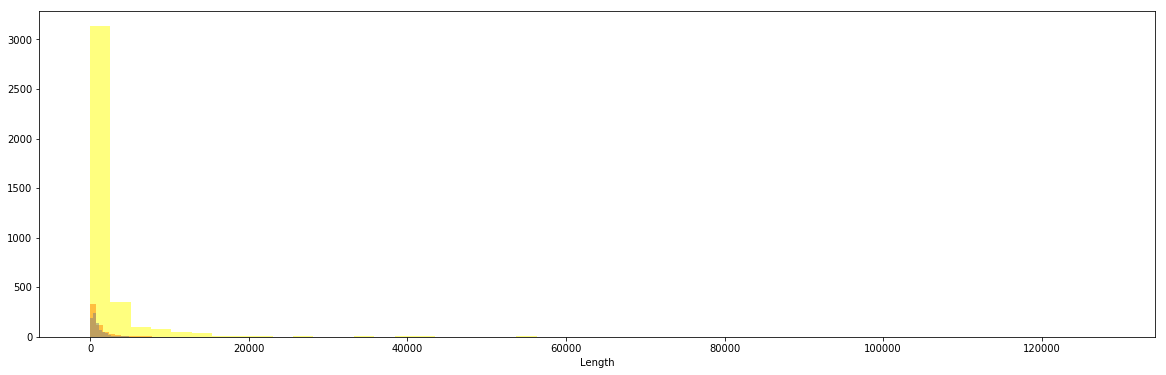

In [ ]:
# Total Char+
sns.distplot( train_data_og.query('sentiment == 0').assign(Length = train_data_og.text.str.lower().str.len())["Length"], color = "red", hist_kws = {"alpha" : .50}, kde = False )
sns.distplot( train_data_og.query('sentiment == 1').assign(Length = train_data_og.text.str.lower().str.len())["Length"], color = "blue", hist_kws = {"alpha" : .50}, kde = False )
sns.distplot( train_data_og.query('sentiment == 2').assign(Length = train_data_og.text.str.lower().str.len())["Length"], color = "yellow", hist_kws = {"alpha" : .50}, kde = False )

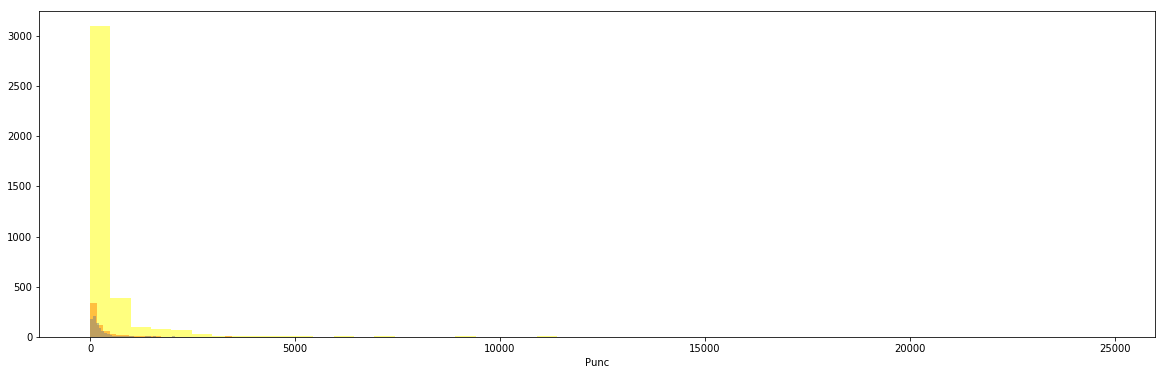

In [ ]:
# Total Char
sns.distplot( train_data_og.query('sentiment == 0').assign(Punc = train_data_og.text.str.lower().str.len() - train_data_og.text.str.lower().str.count("[a-z0-9]"))["Punc"], color = "red", hist_kws = {"alpha" : .50}, kde = False )
sns.distplot( train_data_og.query('sentiment == 1').assign(Punc = train_data_og.text.str.lower().str.len() - train_data_og.text.str.lower().str.count("[a-z0-9]"))["Punc"], color = "blue", hist_kws = {"alpha" : .50}, kde = False )
sns.distplot( train_data_og.query('sentiment == 2').assign(Punc = train_data_og.text.str.lower().str.len() - train_data_og.text.str.lower().str.count("[a-z0-9]"))["Punc"], color = "yellow", hist_kws = {"alpha" : .50}, kde = False )

In [ ]:
# DO NOT DELETE
# from sklearn.feature_extraction.text import CountVectorizer

# vectorizer = CountVectorizer(stop_words = "english")
# train_data = vectorizer.fit_transform(train_data_og.text)

# print(train_data.toarray().shape) 

# len(vectorizer.get_feature_names())
# pd.DataFrame(train_data.toarray(), columns=vectorizer.get_feature_names())

CountVectorizer(analyzer='word', binary=False, decode_error='strict',
                dtype=<class 'numpy.int64'>, encoding='utf-8', input='content',
                lowercase=True, max_df=1.0, max_features=None, min_df=1,
                ngram_range=(1, 1), preprocessor=None, stop_words='english',
                strip_accents=None, token_pattern='(?u)\\b\\w\\w+\\b',
                tokenizer=None, vocabulary=None)

## EDA

seaborn or pandas plot as required.  
verify labels truth - a new column called sample_weights may be helpful for noisy data.

### Distribution

In [ ]:
plt.subplot(1,2,1)
sns.countplot(train_data.XXX, order = train_data.xxx.values_count().index )
plt.subplot(1,2,2)
sns.countplot(sub_data.XXX, order = [1,2,3,4])
plt.show()

### Univariate

Distributions, Outliers

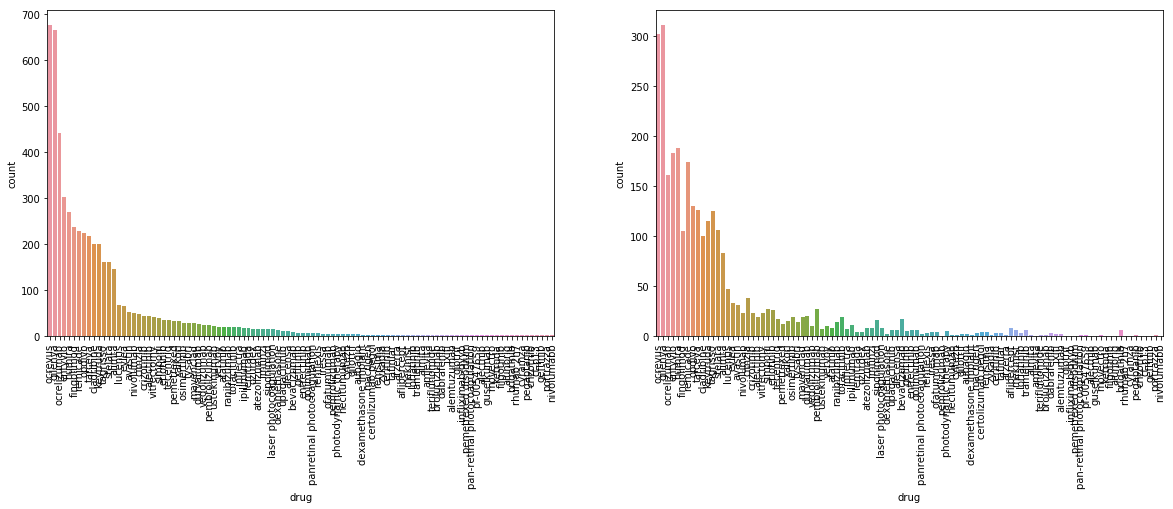

In [ ]:
plt.subplot(1,2,1)
sns.countplot(train_data_og.drug, order = train_data_og.drug.value_counts().index )
plt.xticks(rotation=90)

plt.subplot(1,2,2)
sns.countplot(sub_data_og.drug, order = train_data_og.drug.value_counts().index)
plt.xticks(rotation=90)
plt.show()

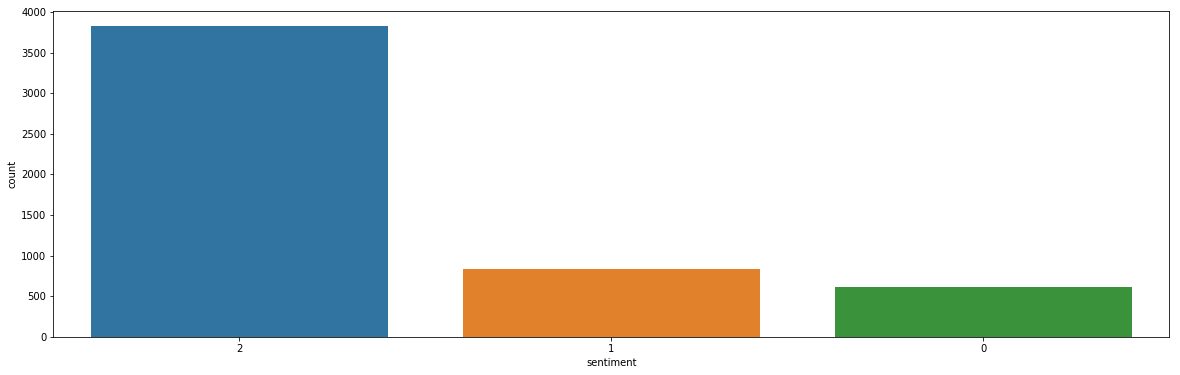

In [ ]:
# 0 positive, 1 negative and 2 neutral

sns.countplot(train_data_og.sentiment, order = train_data_og.sentiment.value_counts().index )
# plt.xticks(rotation=90)
plt.show()

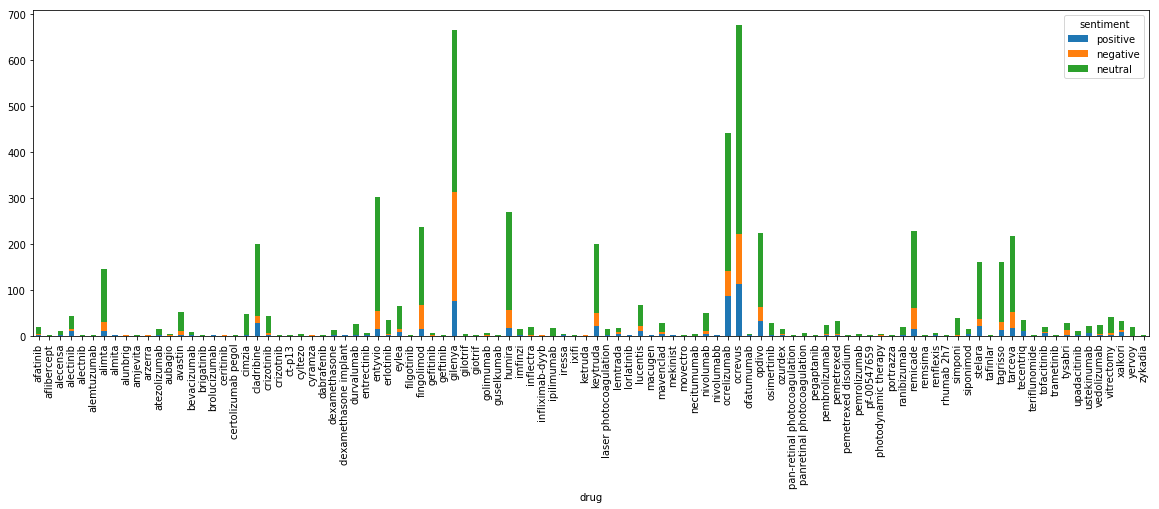

In [ ]:
( train_data_og
    .groupby(["drug", "sentiment"])
    .size()
    .reset_index()
    .pivot(columns='sentiment', index='drug', values=0)
    .rename(columns = {0 : 'positive', 1 : 'negative', 2 : 'neutral'})
    .plot(kind='bar', stacked=True) 
)

### Bivariate

Comparision, corelation

In [ ]:
plt.subplot(1,2,1)
sns.countplot(train_data.XXX, order = train_data.xxx.values_count().index )
plt.subplot(1,2,2)
sns.countplot(sub_data.XXX, order = [1,2,3,4])
plt.show()

### With sub_data

Submit pattern, cv on, splitted on

## Data Validation

Replace xxx with proper data  

1) Random split
2) Catogorical split
3) Time based split

In [ ]:
X_train, X_test = train_test_split(train_data_og, test_size = 0.25, train_size = 0.75, random_state = 42)

print("Train set shape is %s" % X_train.shape[0])
print("Test set shape is %s" % X_test.shape[0])
print("Submission set shape is %s" % sub_data_og.shape[0])

Train set shape is 3959
Test set shape is 1320
Submission set shape is 2924


In [ ]:
# X = train_data.drop(['xxx'], axis = 1)
# y = train_data["xxx"]

# cat_train, cat_test, y_train, y_test = train_test_split(X, y, test_size = 0.25, train_size = 0.75, stratify = train_data["xxx"])

# X = pd.get_dummies(X) #, dummy_na = True
# X_sub = pd.get_dummies(sub_data)

# X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.25, train_size = 0.75, stratify = train_data["xxx"])

In [ ]:
# print("Train set rows %s, cols %s and y is %s" % (X_train.shape[0], X_train.shape[1], y_train.shape[0]))
# print("Test set rows %s, cols %s and y is %s" % (X_test.shape[0], X_test.shape[1], y_test.shape[0]))
# print("Submission set rows %s, cols %s and y is to be predicted" % (X_sub.shape[0], X_sub.shape[1]))

In [ ]:
# # Run only if required

# for x in set(X_train.columns) - set(X_sub.columns) :
#     X_sub[x] = 0

# X_sub = X_sub[X.columns]
    
# print("Submission set rows %s, cols %s and y is to be predicted" % (X_sub.shape[0], X_sub.shape[1]))

### Validataion EDA

## Modeling

For Regression verify distribution.  
For Classification verify confusion matrix.  
Use 10 fold cross validation to verify final model.  

### Submission Part

Ensure that model is trained on whole set

### XGBoost

Monitor metric performance on both train and test.  

In [ ]:

xgb_model = xgb.XGBClassifier(learning_rate=0.01, scale_pos_weight = weight, n_estimators = 100000)
xgb_model.fit(X_train, y_train, eval_metric = "xxx", eval_set = [(X_train, y_train), (X_test, y_test)], verbose = 1000, early_stopping_rounds=10)

#joblib.dump(xgb_model, "drive/My Drive/PyColab Work/xxx/xgb_model.sav")
#confusion_matrix(y_train, xgb_model.predict(X_train))

In [ ]:
100 - np.sqrt(mean_squared_error(y_train, xgb_model.predict(X_train)))

In [ ]:
100 - np.sqrt(mean_squared_error(y_test, xgb_model.predict(X_test)))

In [ ]:
groups = X_train[["Transmission", "Fuel_Type_CNG", "Fuel_Type_Diesel", "Fuel_Type_Electric", "Fuel_Type_LPG", "Fuel_Type_Petrol"]]

cross_val_score(xgb_model, X_train, y_train, cv = 5, groups = groups) # Add Fuel Type as well

In [ ]:
plt.figure(figsize = (20, 5))
sns.barplot("feature", "imp", data = pd.DataFrame( {'feature' : X_train.columns, 'imp' : xgb_model.feature_importances_ }).sort_values("imp", ascending = False) )
plt.xticks(rotation = 90)
plt.show()

#### SHAP

In [ ]:
explainer = shap.TreeExplainer(xgb_model)

nsize = 1000

shap_values = explainer.shap_values(X_train.iloc[0:nsize,:])
shap.summary_plot(shap_values, X_train.iloc[0:nsize,:])

plt.show()

In [ ]:
shap_values = explainer.shap_values(X_test.iloc[0:nsize,:])
b = shap.summary_plot(shap_values, X_test.iloc[0:nsize,:])

#### Hyperparameter Tuning

Draw appropriate graph to understand impact of two hyperparameters.  
eg: rounds to maxdepth can give an idea where it overfits.

##### GridSearchCV

In [ ]:
cv= RepeatedKFold(2, 2)
xgb_engine = xgb.XGBRegressor() #n_estimator not used
xgb_params = {'booster' : ['gbtree'],
              'max_depth' : [3, 4], 
              'gamma' : [0], 
              'learning_rate' : [0.3], 
              "n_estimators" : [100000], 
              'min_child_weight' : [5, 10], 
              'subsample' : [1], 
              'colsample_bytree' : [0.7, 1], 
              'colsample_bylevel' : [1], 
              'colsample_bynode' : [1], 
              'reg_lambda' : [0], 
              'reg_alpha' : [0]}

xgb_grid = GridSearchCV(xgb_engine, xgb_params, cv = cv, n_jobs = 4, verbose = 0, return_train_score  = True)
xgb_grid.fit(X_train, y_train, eval_set = [(X_train, y_train)], early_stopping_rounds=10, verbose = 1000)

#joblib.dump(xgb_grid, "F:/Vasim/Python Stuff/Flight/gridxgboost.sav")

#print( np.sqrt( -cross_val_score(xgb_grid.best_estimator_, X_train, y_train, cv = cv, scoring = "neg_mean_squared_error") ) )
#print( np.sqrt( mean_squared_error(y_test, xgb_grid.predict(X_test)) ) )

##### Skopt

In [ ]:
from skopt.space import Integer, Categorical, Real
from skopt.utils import use_named_args
from skopt import gp_minimize

# set up hyperparameter space
space = [Integer(3, 50, name='max_depth'),
         Integer(8, 200, name='n_estimators'),
         Integer(3, 50, name='min_child_weight'),
         Real(0.001, 1.0, name='learning_rate')]

regressor = xgb.XGBRegressor()

from sklearn.model_selection import cross_val_score

@use_named_args(space)
def objective(**params):
    regressor.set_params(**params)
    return -np.mean(cross_val_score(regressor, X_train, y_train, cv=5, n_jobs=1, scoring='neg_mean_squared_error'))

In [ ]:
reg_gp = gp_minimize(objective, space, verbose=False)

print('best score: {}'.format(reg_gp.fun))

print('best params:')
print('        max_depth: {}'.format(reg_gp.x[0]))
print('     n_estimators: {}'.format(reg_gp.x[1]))
print(' min_child_weight: {}'.format(reg_gp.x[2]))
print('    learning_rate: {}'.format(reg_gp.x[3]))

In [ ]:
import skopt.plots
skopt.plots.plot_convergence(reg_gp)

In [ ]:
skopt.plots.plot_evaluations(reg_gp, bins = 20)
plt.show()

In [ ]:
skopt.plots.plot_objective(reg_gp)
plt.show()

##### Hyperopt

### LightGBM
Inbuilt Categorical features

In [ ]:
lgbm_model = lgb.LGBMRegressor(learning_rate=0.01, n_estimators=100000)
lgbm_model.fit(X_train, y_train, eval_set = [(X_test, y_test)], early_stopping_rounds=100, verbose = 1000)

#### SHAP

In [ ]:
explainer = shap.TreeExplainer(lgbm_model)

nsize = 1000

shap_values = explainer.shap_values(X_train.iloc[0:nsize,:])
shap.summary_plot(shap_values, X_train.iloc[0:nsize,:])

plt.show()

#### Hyperparamter Tuning

In [ ]:
lgbm_engine = lgb.LGBMRegressor()
lgbm_params = {'max_depth' : [17], 'learning_rate' : [0.05], 'n_estimators': [100000],  'min_child_samples' : [3], 'num_leaves' : [40], 'min_child_weight' : [0.001], 
               'min_split_gain' : [0], 'colsample_bytree' : [0.3], 'reg_alpha' : [0], 'reg_lamba' : [0], 'importance_type' : ['split'] }

lgbm_grid = GridSearchCV(lgbm_engine, lgbm_params, cv = 4, n_jobs = 4, verbose = 0)
lgbm_grid.fit(X_train, y_train, eval_set = [(X_test, y_test)], early_stopping_rounds=100, verbose = 1000)
#print( np.sqrt( -cross_val_score(lgbm_grid.best_estimator_, X_train, y_train, cv = 5, scoring = "neg_mean_squared_error") ) )
#print( np.sqrt( mean_squared_error(y_test, lgbm_grid.predict(X_test)) ) )

### CatBoost

Inbuilt Categorical features  

The cat.cv - inbuilt cross validation gives cross validated result on each iterations.   
The only hyperparameter we can select from in built cv is no of iteration.  
Try sklearn cv type with for loop for cv score or skopt or hyperopt module.  

In [ ]:
from catboost import CatBoostRegressor, Pool
categorical_features_indices = np.where(cat_train.dtypes == 'object')[0]

cat_model = CatBoostRegressor(iterations = 100000, learning_rate = 0.01)
cat_model.fit(cat_train, y_train, eval_set = (cat_test, y_test), cat_features = categorical_features_indices, plot = True, verbose = 1000, early_stopping_rounds=100)

#print( np.sqrt( -cross_val_score(cat_model, X_train, y_train, cv = 5, scoring = "neg_mean_squared_error", verbose = False) ) )
#np.sqrt(mean_squared_error(y_test, cat_model.predict(X_test)))

#### SHAP

In [ ]:
explainer = shap.TreeExplainer(cat_model)

nsize = 1000

shap_values = explainer.shap_values(X_train.iloc[0:nsize,:])
shap.summary_plot(shap_values, X_train.iloc[0:nsize,:])

plt.show()

#### Hyperparamter Tuning

In [ ]:
cat_engine = CatBoostRegressor()
cat_params = {'max_depth' : [4], 'learning_rate' : [0.1], 'iterations': [100000], 'colsample_bylevel' : [1]}
    
cat_grid = GridSearchCV(cat_engine, cat_params, cv = 4, n_jobs = 4, verbose = False)
cat_grid.fit(cat_train, y_train, eval_set = (cat_val, y_val), cat_features = categorical_features_indices, plot = True, verbose = 1000, early_stopping_rounds=100)

### SVM

Apply scaling

In [ ]:
#%%script false

from sklearn.svm import SVR
from sklearn.preprocessing import StandardScaler, MinMaxScaler

#Scaling only on numeric data.
svmpipe = Pipeline([ ( "std", StandardScaler() ), ("mimax", MinMaxScaler()) , ( "svm", SVR(gamma = 'scale', kernel = 'rbf', C = 1.5, epsilon = 0.1, max_iter=-1) ) ])
svmpipe.fit(X_train, y_train)

#np.sqrt( -cross_val_score(svmpipe, X_train.astype(float), y_train.astype(float), cv = 5, scoring = "neg_mean_squared_error") )
np.sqrt( mean_squared_error(y_test, svmpipe.predict(X_test))) 

#### SHAP

#### Hyperparamter Tuning

### KNN

Apply scaling

In [ ]:
from sklearn.neighbors import KNeighborsRegressor
from sklearn.preprocessing import StandardScaler, normalize, MinMaxScaler

#Scaling on numeric data only
neigh = KNeighborsRegressor(n_neighbors=5)
knnpipe = Pipeline([ ( "std", StandardScaler() ), ("minmax", MinMaxScaler() ), ( "knn", neigh ) ])

#scale data
knnpipe.fit(X_train, y_train) 
print( np.sqrt( -cross_val_score(neigh, X_train, y_train, cv = 5, scoring = "neg_mean_squared_error") ) )
#np.sqrt(mean_squared_error(y_test, neigh.predict(X_test)))

#### SHAP

#### Hyperparamter Tuning

### Keras

Apply scaling

In [ ]:
#!pip install tensorboardcolab
# Apply scaling

from tensorboardcolab import TensorBoardColab, TensorBoardColabCallback
from keras.models import Sequential
from keras.layers import Dense, Dropout
#tbc=TensorBoardColab()

model2 = Sequential()
model2.add(Dense(200, input_dim=X_train.shape[1], kernel_initializer='normal', activation='relu'))
model2.add(Dense(30, kernel_initializer='normal', activation='relu'))
model2.add(Dropout(.10))
#model.add(Dense(10, kernel_initializer='normal', activation='relu'))
#model.add(Dropout(.10))
model2.add(Dense(1, kernel_initializer='normal'))

model2.compile(loss='mean_squared_error', optimizer='adam')

model2.fit(X_train, y_train, epochs = 18, verbose = 0) #callbacks=[TensorBoardColabCallback(tbc)]
pd.DataFrame( {"Actual" : np.exp(y_test), "Predict" : np.exp(model2.predict(X_test)[0:,0])} ).describe()

#### SHAP

#### Hyperparamter Tuning

### Linear

inludes - Logistic  
Panelty - Ridge, Lasso and ElasticNet  


In [ ]:
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.linear_model import LogisticRegressionCV
from sklearn.pipeline import make_pipeline

# vec = CountVectorizer(stop_words="english")
# clf = LogisticRegressionCV()
# pipe = make_pipeline(vec, clf)
# pipe.fit(X_train.text, X_train.sentiment);

In [ ]:
f1_score(X_test.sentiment, pipe.predict(X_test.text), average = "macro")

0.3277842887837599

In [ ]:
from sklearn import metrics

def print_report(pipe):
    y_test = X_test.sentiment
    y_pred = pipe.predict(X_test.text)
    report = metrics.classification_report(y_test, y_pred) # target_names=train_data_og.sentiment
    print(report)
    print("accuracy: {:0.5f}".format(metrics.accuracy_score(y_test, y_pred)))
    print("f1 score: {:0.5f}".format(f1_score(y_test, y_pred, average = "macro")))


In [ ]:
import eli5
eli5.show_weights(clf, vec=vec, top=10,
                  target_names=train_data_og.sentiment)

Weight,Feature
0.0056,relapsing ms
0.0052,disability progression
0.0051,high efficacy
0.0051,results presented
0.0049,lung cancer
0.0049,cell lung
0.0049,april 2016
0.0049,felt like
0.0049,ulcerative colitis
0.0049,non small


In [ ]:
# targets=[0]
print("actual", X_test.sentiment.iloc[0])

eli5.show_prediction(clf, X_test.text.iloc[0], vec=vec,
                     target_names=X_test.sentiment)  

In [ ]:
# from sklearn.feature_extraction.text import TfidfVectorizer

# vec = TfidfVectorizer()
# clf = LogisticRegressionCV()
# pipe = make_pipeline(vec, clf)
# pipe.fit(X_train.text, X_train.sentiment)

# print_report(pipe)

In [ ]:
# https://datascience.stackexchange.com/questions/16342/unbalanced-multiclass-data-with-xgboost

XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bytree=1, gamma=0, learning_rate=0.1, max_delta_step=0,
              max_depth=3, min_child_weight=1, missing=None, n_estimators=100,
              n_jobs=1, nthread=None, objective='binary:logistic',
              random_state=0, reg_alpha=0, reg_lambda=1, scale_pos_weight=1,
              seed=None, silent=True, subsample=1)

In [ ]:
# PCA, ngram
vec = TfidfVectorizer(stop_words = "english", analyzer = "word", ngram_range = (1, 3))
clf = xgb.XGBClassifier(learning_rate=1, max_depth = 7, n_estimators = 100)
pipe = make_pipeline(vec, clf)
pipe.fit(X_train.text, X_train.sentiment)

#print_report(pipe)

Pipeline(memory=None,
         steps=[('tfidfvectorizer',
                 TfidfVectorizer(analyzer='word', binary=False,
                                 decode_error='strict',
                                 dtype=<class 'numpy.float64'>,
                                 encoding='utf-8', input='content',
                                 lowercase=True, max_df=1.0, max_features=None,
                                 min_df=1, ngram_range=(1, 3), norm='l2',
                                 preprocessor=None, smooth_idf=True,
                                 stop_words='english', strip_accents=None,
                                 sublinear_tf=False,...
                ('xgbclassifier',
                 XGBClassifier(base_score=0.5, booster='gbtree',
                               colsample_bylevel=1, colsample_bytree=1, gamma=0,
                               learning_rate=1, max_delta_step=0, max_depth=7,
                               min_child_weight=1, missing=None,
            

In [ ]:
confusion_matrix(X_train.sentiment, X_train.sentiment) #0, 1, 2 <- Positive, Negative and Neutral

array([[ 484,    0,    0],
       [   0,  611,    0],
       [   0,    0, 2864]])

In [ ]:
confusion_matrix(X_train.sentiment, pipe.predict(X_train.text))

array([[ 484,    0,    0],
       [   0,  611,    0],
       [   0,    0, 2864]])

In [ ]:
confusion_matrix(X_test.sentiment, pipe.predict(X_test.text))

array([[ 32,  11,  90],
       [ 25,  64, 137],
       [ 86,  69, 806]])

In [ ]:
# 0.4639868178262077
f1_score(X_test.sentiment, pipe.predict(X_test.text), average = "macro")

0.46208509324814756

In [ ]:
sub_data_og.assign( sentiment = pipe.predict(sub_data_og.text) )[["unique_hash", "sentiment"]].to_csv("xgb05.csv", index = False)

In [ ]:
# Neural Network, RNN, SVM

#### SHAP

In [ ]:
explainer = shap.LinearExplainer(pipe, X_train, feature_dependence="independent")
shap_values = explainer.shap_values(X_test)
X_test_array = X_test.toarray() # we need to pass a dense version for the plotting functions

In [ ]:
shap.summary_plot(shap_values, X_test_array, feature_names=vectorizer.get_feature_names())

In [ ]:
ind = 0
shap.force_plot(
    explainer.expected_value, shap_values[ind,:], X_test_array[ind,:],
    feature_names=vectorizer.get_feature_names()
)

#### Hyperparamter Tuning

## Stacking

In [ ]:
#mlextend